In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.datasets as datasets
import torchvision.utils as vutils

import os
import json
import numpy as np
import csv
import pandas as pd
import math
import numpy as np
import glob
import tqdm
import sys
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg
from tqdm import tqdm
import sklearn
from sklearn.metrics import accuracy_score

import seaborn as sns
sns.set_theme(style="ticks")

import torchvision
from torchvision.io import read_image

# from sdtw_cuda_loss import SoftDTW

In [3]:
# %load_ext tensorboard
# from torch.utils.tensorboard import SummaryWriter

In [4]:
device = torch.device('cuda:1') #  if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=1)

In [5]:
# target_folder = './extracted/mwd/nopims/'
target_folder = '/home/sharifullina/thesis/TIME/extracted/mwd/volve/'
# target_folder = '/Users/ramilasarifullina/Desktop/extracted/well_logs/volve/'
# target_folder = '/Users/ramilasarifullina/Desktop/extracted/well_logs/nopims/'

### Выгрузим датасет Volve и преобразуем данные

In [6]:
wells = os.listdir(target_folder)
required_params_plus = ['DEPTH', 'ROPA', 'HKLA', 'WOB', 'SPPA', 'WELL']
required_params = ['DEPTH', 'ROPA', 'HKLA', 'WOB', 'SPPA']

logs = [json.load(open(os.path.join(target_folder, wells[i]), 'r')) for i in range(len(wells))]

In [7]:
# X_all - Dataframe with all logging while drilling data concatenated

dataset_all = [pd.DataFrame(logs[i]['data'], columns=[x['name'] for x in logs[i]['curves']]) for i in range(len(logs))]
for i in range(len(dataset_all)):
    dataset_all[i]['WELL'] = wells[i]

dataset = []
for df in dataset_all:
    dataset.append(df[required_params_plus])
    
X_all = dataset[0]
for i in range(1, len(dataset)):
    X_all = pd.concat([X_all, dataset[i]], ignore_index = True)
X_all = X_all.ffill().bfill()

# X_list is a list containing a data for all wells splitted to windows with size 256

X_list = []
for i in range(0, len(X_all) - 256, 10):
    X_list.append(X_all[i : 256 + i])

    
# X_list_minus is X_list but without the WELL column
    
X_list_minus = []
for x in X_list:
    X_list_minus.append(x.loc[:, x.columns != 'WELL'])

X_verif_list = X_list_minus
    
# X is an array with the shape = (5901, 256, 5)
    
X = []
for i in X_list_minus:
    X.append(i.values)

X = np.dstack(X)
X = np.rollaxis(X, -1)

# map_well_to_label is dictionary to help to rename wells from 'well_N' to N
map_well_to_label = {w:i for i, w in enumerate(wells)}

# label = well's number
y = np.array([map_well_to_label[df['WELL'].iloc[0]] for df in X_list])


### Импортируем verificator, regulator

In [8]:
from dataset import *
from model import * # GAN model
from inceptiontime.src.models.inception import InceptionModel # Verificator
# Regulator
from time_series_metrics.ssim_loss import SSIM_1d_conv
# from time_series_metrics.tsfresh_metrics import tsfresh_metrics
from time_series_metrics.tsfresh_loss import Mean_similarity_loss, Root_mean_square_similarity_loss, Coisine_between_angles_loss, Pearson_corr_funct_loss, Eucledian_distance_loss


### Загрузим датасет

In [9]:
torch_dataset = DataSet(X, y, sparse_rate=1)
all_loader = DataLoader(torch_dataset, batch_size=64, shuffle=True)


In [10]:
train_n = 5310
train_set, val_set = torch.utils.data.random_split(torch_dataset, [train_n, len(torch_dataset) - train_n])

In [11]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=True)

### создадим датасет для верификатора

In [12]:
# соеденим все логи скважин в один большой pandas.DaraFrame
dataset_all = [pd.DataFrame(logs[i]['data'], columns=[x['name'] for x in logs[i]['curves']]) for i in range(len(logs))]
dataset = []
for df in dataset_all:
    dataset.append(df[required_params])
X_all = dataset[0]
for i in range(1, len(dataset)):
    X_all = pd.concat([X_all, dataset[i]], ignore_index = True)
X_all = X_all.ffill().bfill()

In [13]:
similar_wells = []

for i in range(0, 18400, 20):
    similar_wells.append(X_all[i : 256 + i])
# преобразуем лист в массив с размерностью [20, 256, 5]; 20 - количество скважин, 256 - размерность окна, 
#                                                   5 - количество столбцов = len(required_params)
similar_wells = np.dstack(similar_wells)
similar_wells = np.rollaxis(similar_wells, -1)
similar_wells.shape

(920, 256, 5)

In [14]:
# different_wells = []

# for i in range(0, 256 * 230, 256):
#     different_wells.append(X_all[i : 256 + i])
#     different_wells.append(X_all[i : 256 + i] + np.random.normal(X_all[i : 256 + i].mean(),\
#                                                                  X_all[i : 256 + i].std(), [256, 5]))
#     different_wells.append(X_all[i : 256 + i] + np.random.normal(X_all[i : 256 + i].mean(), \
#                                                                  X_all[i : 256 + i].std(), [256, 5]))
#     different_wells.append(X_all[i : 256 + i] + np.random.normal(X_all[i : 256 + i].mean(),\
#                                                                  X_all[i : 256 + i].std(), [256, 5]))
    
# different_wells = np.dstack(different_wells)
# different_wells = np.rollaxis(different_wells, -1)


import random
different_wells = []

for i in range(0, 256 * 230, 256):
    different_wells.append(X_all[i : i + 256])
    different_wells.append(X_all[i : i + 256])
    different_wells.append(X_all[i : i + 256])
    different_wells.append(X_all[i : i + 256])

random.shuffle(different_wells)
different_wells = np.dstack(different_wells)
different_wells = np.rollaxis(different_wells, -1)

In [15]:
needed = []
for i in range(different_wells.shape[0]):
    needed.append([different_wells[i - 1], different_wells[i], 1])
    needed.append([similar_wells[i - 1], similar_wells[i], 0])

In [16]:
# with open('some.csv', 'w') as f:
#     writer = csv.writer(f)
#     writer.writerow(['time1', 'time2', 'relationshion'])
#     writer.writerows(needed)

In [17]:
# df = pd.read_csv('some.csv')
# df = df.sample(frac=1)
# df.head()

In [18]:
from torch.utils.data import Dataset

class Verification(Dataset):
    def __init__(self, needed, feature_scales_simil={}, feature_scales_diff={}):
        
        self.needed = needed
        self.feature_scales_simil = feature_scales_simil
        self.feature_scales_diff = feature_scales_diff
        
    def __getitem__(self, index):

        time1 = self.needed[index][0]
        time2 = self.needed[index][1]
        relation = self.needed[index][2]
        
        self.time1 = torch.tensor(time1).to(torch.float32)
        self.time2 = torch.tensor(time2).to(torch.float32)
        self.relation = torch.tensor(relation).to(torch.float32)
        
        # time1
        for f in range(self.time1.shape[1]):
            self.time1[:, f] = self.time1[:, f] - self.time1[:, f].mean()
            
        for f in range(self.time1.shape[1]):
            if f not in self.feature_scales_simil:
                std = self.time1[:, f].std()
                self.feature_scales_simil[f] = std
            self.time1[:, f] = self.time1[:, f] / self.feature_scales_simil[f]
            
        # time2
        for f in range(self.time2.shape[1]):
            self.time2[:, f] = self.time2[:, f] - self.time2[:, f].mean()
            
        for f in range(self.time2.shape[1]):
            if f not in self.feature_scales_diff:
                std = self.time2[:, f].std()
                self.feature_scales_diff[f] = std
            self.time2[:, f] = self.time2[:, f] / self.feature_scales_diff[f]
            
        self.time1 = self.time1.transpose(0, 1)
        self.time2 = self.time2.transpose(0, 1)

        return self.time1, self.time2, self.relation

    def __len__(self):
        return len(self.needed)
    

In [19]:
verif_dataset = Verification(needed)
verif_loader = DataLoader(verif_dataset, batch_size=64, shuffle=True)

In [20]:
# test
for time1, time2, label in verif_loader:
    print(time1.shape)
    print(time2.shape)
    print(label)
    break

torch.Size([64, 5, 256])
torch.Size([64, 5, 256])
tensor([1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
        0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0.,
        1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1.,
        1., 0., 0., 1., 0., 0., 0., 1., 1., 0.])


### Train verification model

In [21]:
model_verification = InceptionModel(num_blocks=2, in_channels=len(required_params), 
                       out_channels=30,
                       bottleneck_channels=12, kernel_sizes=15,
                       use_residuals=True, 
                       num_pred_classes=len(wells)).to(device)

optimizer_verification = torch.optim.Adam(model_verification.parameters(), lr=1e-3)

In [22]:
class VerificationLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(VerificationLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        pos = (1-label) * torch.pow(euclidean_distance, 2)
        neg = (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        loss_contrastive = torch.mean( pos + neg )
        return loss_contrastive

criterion_verification = VerificationLoss()

Epoch [0/100] Loss V: 0.5331
Epoch [10/100] Loss V: 0.2501
Epoch [20/100] Loss V: 0.2453
Epoch [30/100] Loss V: 0.2200
Epoch [40/100] Loss V: 0.2654
Epoch [50/100] Loss V: 0.4961
Epoch [60/100] Loss V: 0.3439
Epoch [70/100] Loss V: 0.2103
Epoch [80/100] Loss V: 0.2380
Epoch [90/100] Loss V: 0.1603


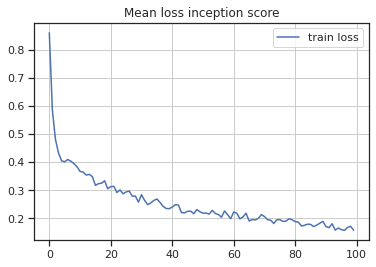

In [23]:
best_train_acc = 0
train_loss = []
train_acc = []
num_epochs = 100
patience_counter = 0
best_state_dict = None

for epoch in range(num_epochs):
    model_verification.train();
    epoch_train_loss = []
    all_preds = []
    all_y = []
    for time1, time2, label in verif_loader:
        time1 = time1.to(device)
        time2 = time2.to(device)
        label = label.to(device)
        optimizer_verification.zero_grad()
        encoded_1 = model_verification(time1) 
        encoded_2 = model_verification(time2)
        loss = criterion_verification(encoded_1, encoded_2, label)
        epoch_train_loss.append(loss.item())
        loss.backward()
        optimizer_verification.step()
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}] Loss V: {loss.item():.4f}")
    train_loss.append(np.mean(epoch_train_loss))


plt.plot(train_loss, label = 'train loss')
plt.legend()
plt.grid()
plt.title('Mean loss inception score')
plt.show()

torch.save({
    'model_state_dict': model_verification.state_dict(),
}, 
    'trained_models/model_verification.pt'
)

In [24]:
model_verification = InceptionModel(num_blocks=2, in_channels=len(required_params), 
                                    out_channels=30,
                                    bottleneck_channels=12, kernel_sizes=15,
                                    use_residuals=True, 
                                    num_pred_classes=len(wells)).to(device)
checkpoint = torch.load('trained_models/model_verification.pt')
model_verification.load_state_dict(checkpoint['model_state_dict'])
# model_verification.eval()

<All keys matched successfully>

### check smth

In [25]:
def add_noise(x, noise_rate):
    x = x + (torch.randn_like(x) * noise_rate).to(device)
    return x

class AutoEncoder(nn.Module):
    def __init__(self, in_channels, conv1_channels=20, conv2_channels=50, 
                 K1=10, P1=5, S1=2, K2=5, P2=2, S2=2,
                 interm_lsz=400, pre_hidden_sz=50, hidden_lsz=20):
        super(AutoEncoder, self).__init__()
        self.in_channels = in_channels
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=conv1_channels, 
                               kernel_size=K1, padding=P1, stride=S1)
        conv1_L = (L - K1 + 2*P1)//S1 + 1
        print('conv1_L', conv1_L)
        conv1_sz = conv1_channels * conv1_L
        print('conv1_sz', conv1_sz)
        self.conv2 = nn.Conv1d(in_channels=conv1_channels + in_channels, # gradient flow
                               out_channels=conv2_channels, 
                               kernel_size=K2, padding=P2, stride=S2)
        conv2_L = (conv1_L - K2 + 2*P2)//S2 + 1
        print('conv2_L', conv2_L)
        conv2_sz = conv2_channels * conv2_L
        print('conv2_sz', conv2_sz)
        self.fce1 = nn.Linear(conv2_sz, interm_lsz)
        self.fce2 = nn.Linear(interm_lsz, pre_hidden_sz)
        self.fce3 = nn.Linear(pre_hidden_sz, hidden_lsz)
        self.fcd1 = nn.Linear(hidden_lsz, pre_hidden_sz)
        self.fcd2 = nn.Linear(pre_hidden_sz, interm_lsz)
        self.fcd3 = nn.Linear(interm_lsz, conv2_sz)
        deconv4_L = (conv2_L - 1) * S2 - 2 * P2 + K2
        print('deconv4_L', deconv4_L)
        self.deconv4 = nn.ConvTranspose1d(in_channels=conv2_channels, 
                                          out_channels=conv1_channels + in_channels, # gradient flow 
                                          kernel_size=K2, padding=P2, stride=S2, 
                                          output_padding=conv1_L - deconv4_L)
        deconv5_L = (conv1_L - 1) * S1 - 2 * P1 + K1
        print('deconv5_L', deconv5_L)
        self.deconv5 = nn.ConvTranspose1d(in_channels=conv1_channels, out_channels=in_channels, 
                                          kernel_size=K1, padding=P1, stride=S1,
                                          output_padding=L - deconv5_L)
        self.reset_parameters()
        

    def encode(self, x, noise_rate, alpha=0.):
        h0 = self.conv1(x.transpose(1, 2))
        h0_downscale = nn.functional.avg_pool1d(x.transpose(1, 2), kernel_size=2, stride=2, padding=1)
        h0 = torch.cat((h0_downscale, h0), dim=1)
        h0 = add_noise(h0, noise_rate)
        h0 = F.leaky_relu(h0)
        h0 = self.conv2(h0)
        h0 = add_noise(h0, noise_rate)
        h0 = F.leaky_relu(h0.view(h0.shape[0], -1))
        h1 = self.fce1(h0)
        h1 = add_noise(h1, noise_rate)
        h1 = F.leaky_relu(h1)
        
        h2 = self.fce2(h1)
        h2 = add_noise(h2, noise_rate)
        h2 = F.leaky_relu(h2)
        return self.fce3(h2)

    def decode(self, z, noise_rate=0., alpha=0.):
        h1 = F.leaky_relu(self.fcd1(z))
        h1 = add_noise(h1, noise_rate)
        h2 = F.leaky_relu(self.fcd2(h1))
        h2 = add_noise(h2, noise_rate)
        h3 = F.leaky_relu(self.fcd3(h2))
        h3 = add_noise(h3, noise_rate)
        h4 = self.deconv4(h3.view(z.shape[0], self.deconv4.in_channels, -1))
        h4 = add_noise(h4, noise_rate)
        h4_upscale = h4[:, :self.in_channels, :]
        h4 = h4[:, self.in_channels:, :]
        h4 = F.leaky_relu(h4)
        h4 = self.deconv5(h4)
        h4_upscale = nn.functional.interpolate(h4_upscale, mode='linear', size=h4.shape[-1])
        h4 = (0.5*h4 + 0.5*h4_upscale).transpose(1, 2)
        return h4


    def forward(self, x, noise_rate=0, latent_noise_rate=0, alpha=0):
        x = add_noise(x, noise_rate)
        z = self.encode(x, noise_rate, alpha)
        z = add_noise(z, latent_noise_rate)
        return self.decode(z, noise_rate, alpha)
    
    def reset_parameters(self):
        init_range = 0.025
        for param in self.parameters():
            param.data.uniform_(-init_range, init_range)

In [26]:
# GANs hyperparamters
lr = 3e-4
batch_size = 64
num_epochs = 100
n_noise = 256
n_critic = 1
# fixed_noise = torch.randn((batch_size, len(required_params), 256)).to(device)
latent_dim = 256
L = 256
model_ae = AutoEncoder(in_channels=len(required_params), 
                       conv1_channels=50, 
                       conv2_channels=100, 
                       interm_lsz=1000, 
                       pre_hidden_sz=200, 
                       hidden_lsz=latent_dim).to(device)

disc_ae = Discriminator().to(device)

D_opt_ae = torch.optim.Adam(disc_ae.parameters(), lr = lr)
G_opt_ae = torch.optim.Adam(model_ae.parameters(), lr = lr)

criterion_ae = nn.BCELoss()

conv1_L 129
conv1_sz 6450
conv2_L 65
conv2_sz 6500
deconv4_L 129
deconv5_L 256


In [27]:
for idx, data_all in enumerate(train_loader):
    real_data, y = data_all
    real_data = real_data.transpose(1, 2).to(device)
    print(real_data.shape)
    print(model_ae(real_data).transpose(1, 2).shape)
    break

torch.Size([64, 256, 5])
torch.Size([64, 5, 256])


### Training models

In [28]:
def train(loader, 
          gen, 
          disc, 
          criterion_gan, 
          G_opt, 
          D_opt, 
          model_verification, 
          criterion_verification, 
          criterion_regulator,
          save_PATH, 
          lr, batch_size, num_epochs, n_noise, n_critic):
    
    de_ident_rate_list = []
    simil_index = 0

    G_losses = []
    D_losses = []
    R_losses = []
    V_losses = []
    V_losses2 = []
    verificator_labels = []
    verificator_preds = []

    torch.cuda.empty_cache()

    for epoch in range(num_epochs):
        for idx, data_all in enumerate(loader):
            # data preprocessing
            step = 0
            real_data, y = data_all
            real_data, y = real_data.to(device), y.to(device)
            batch_size = real_data.size(0)

            # DISCRIMINATOR TRAINING == maximize D(real_data) + (1 - D(G(noise)))
            gen.eval()
            disc.train()
            D_opt.zero_grad()

            fake = gen(real_data.transpose(1, 2))
            disc_real = disc(real_data)        
            D_loss_1 = criterion_gan(disc_real, torch.ones_like(disc_real))
            disc_fake = disc(fake.transpose(1, 2))
            D_loss_2 = criterion_gan(disc_fake, torch.zeros_like(disc_fake))
            
            # verificator loss
            model_verification.eval()
            embeding_fake = model_verification(fake.transpose(1, 2))
            embeding_real = model_verification(real_data)
            label = torch.ones(batch_size).to(device)
            loss_verif = criterion_verification(embeding_real, embeding_fake, label)
            V_losses.append(loss_verif.item())
            
            # de-identification rate
            pred_equal_y = torch.tensor([embeding_fake[i, y[i] - 1].item() for i in range(len(y))]).to(device)
            pred_max = torch.max(embeding_fake, dim = 1)[0]
            de_ident_rate_list.append((pred_equal_y < pred_max).float().mean())
            
            # similarity loss
            if criterion_regulator != Eucledian_distance_loss:
                loss_regul = criterion_regulator()(real_data, fake.transpose(1, 2))
            else:
                loss_regul = criterion_regulator()(real_data, fake.transpose(1, 2)) / 1000
            R_losses.append(loss_regul.item())
            
            D_loss = (D_loss_1 + D_loss_2) / 2 + loss_verif.detach() + loss_regul.detach()
            D_losses.append(D_loss.item())
            D_loss.backward() # retain_graph = True
            D_opt.step()
            
            # GENERATOR TRAINING == maximize D(G(noise))
            gen.train()
            disc.eval()
            G_opt.zero_grad()

            fake = gen(real_data.transpose(1, 2))
            output = disc(fake.transpose(1, 2))
            G_loss = criterion_gan(output, torch.ones_like(output))
            G_losses.append(G_loss.item())
            G_loss.backward() 
            G_opt.step()

        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {idx}/{len(loader)} Loss D: {D_loss.item():.4f}, Loss G: {G_loss.item():.4f}, Loss V: {loss_verif.item():.4f}, Loss R: {loss_regul.item():.4f}")


            step += 1
            
    de_ident_rate = (sum(de_ident_rate_list) / len(de_ident_rate_list)).item()
    str_simil = 1 - sum(R_losses) / len(R_losses)
                    
    torch.save({
        'gen_state_dict': gen.state_dict(),
        'disc_state_dict': disc.state_dict(),
        'de_ident_rate': de_ident_rate,
        'str_simil': str_simil
    }, save_PATH)
    
    return G_losses, D_losses, R_losses, V_losses, V_losses2

### models training

In [29]:
for idx, data_all in enumerate(train_loader):
    real_data, y = data_all
    print(real_data.shape)
    break

torch.Size([64, 5, 256])


In [30]:
losses_ae = train(loader = train_loader, 
                  gen = model_ae, 
                  disc = disc_ae, 
                  criterion_gan = criterion_ae, 
                  G_opt = G_opt_ae, 
                  D_opt = D_opt_ae, 
                  model_verification = model_verification, 
                  criterion_verification = criterion_verification, 
                  criterion_regulator = Mean_similarity_loss,
                  save_PATH = 'trained_models/gan_ae.pt', 
                  lr = lr, 
                  batch_size = batch_size, 
                  num_epochs = num_epochs, 
                  n_noise = n_noise, 
                  n_critic = n_critic)

Epoch [0/100] Batch 82/83 Loss D: 0.1893, Loss G: 0.3441, Loss V: 0.0000, Loss R: 0.0000
Epoch [10/100] Batch 82/83 Loss D: 0.0012, Loss G: 0.2045, Loss V: 0.0000, Loss R: 0.0000
Epoch [20/100] Batch 82/83 Loss D: 0.0009, Loss G: 0.3439, Loss V: 0.0000, Loss R: 0.0000
Epoch [30/100] Batch 82/83 Loss D: 0.0005, Loss G: 0.4028, Loss V: 0.0000, Loss R: 0.0000
Epoch [40/100] Batch 82/83 Loss D: 0.0012, Loss G: 2.8454, Loss V: 0.0000, Loss R: 0.0000
Epoch [50/100] Batch 82/83 Loss D: 0.0433, Loss G: 3.2101, Loss V: 0.0000, Loss R: 0.0000
Epoch [60/100] Batch 82/83 Loss D: 0.0001, Loss G: 3.0274, Loss V: 0.0000, Loss R: 0.0000
Epoch [70/100] Batch 82/83 Loss D: 0.0001, Loss G: 3.1258, Loss V: 0.0000, Loss R: 0.0000
Epoch [80/100] Batch 82/83 Loss D: 0.0000, Loss G: 2.4979, Loss V: 0.0000, Loss R: 0.0000
Epoch [90/100] Batch 82/83 Loss D: 0.0001, Loss G: 2.8372, Loss V: 0.0000, Loss R: 0.0000


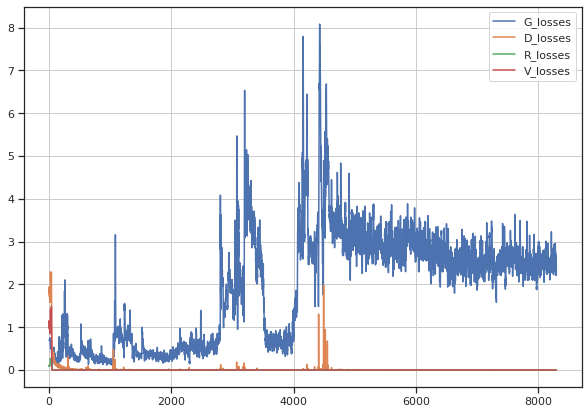

In [31]:
plt.figure(figsize=(10, 7))
plt.plot(losses_ae[0], label = 'G_losses')
plt.plot(losses_ae[1], label = 'D_losses')
plt.plot(losses_ae[2], label = 'R_losses')
plt.plot(losses_ae[3], label = 'V_losses')
plt.legend()
plt.grid()
plt.show()

In [32]:
model_ae = AutoEncoder(in_channels=len(required_params), 
                       conv1_channels=50, 
                       conv2_channels=100, 
                       interm_lsz=1000, 
                       pre_hidden_sz=200, 
                       hidden_lsz=latent_dim).to(device)
disc_ae = Discriminator().to(device)

checkpoint_ae = torch.load('trained_models/gan_ae.pt')

model_ae.load_state_dict(checkpoint_ae['gen_state_dict'])
disc_ae.load_state_dict(checkpoint_ae['disc_state_dict'])
de_ident_rate_ae = checkpoint_ae['de_ident_rate']
str_simil_ae = checkpoint_ae['str_simil']
print(de_ident_rate_ae)
print(str_simil_ae)
# gen_ms.eval()

conv1_L 129
conv1_sz 6450
conv2_L 65
conv2_sz 6500
deconv4_L 129
deconv5_L 256
0.9844456315040588
0.9988402814286983


## test

In [33]:
scales_vectors = np.array([torch_dataset.feature_scales[f] for f in range(len(required_params))])

sparse_rate = torch_dataset.sparse_rate
print('sparse_rate', sparse_rate)
L = 64
print('L', L)
# window = L * sparse_rate
window = 256
print('window', window)
step = 4
print('step', step)

sparse_rate 1
L 64
window 256
step 4


In [34]:
test_well = wells[22]
test_well

'well_17.json'

In [35]:
X_test = pd.DataFrame(logs[22]['data'], columns=[x['name'] for x in logs[22]['curves']])
X_test = X_test[required_params]
X_test = X_test.drop_duplicates()

In [36]:
y_name = 'DEPTH'


In [37]:
###################### CHECK ######################
# t = X_test[y_name][:256].astype(float).values
# x = X_test[required_params][:256].values

# mean_x = x.mean(axis=0)
# x = (x - mean_x) / scales_vectors
# with torch.no_grad():
#     x = torch.Tensor(x).view(1, x.shape[0], -1).to(device)
#     z = gen_ms(x.transpose(1, 2))
    
# z = z.transpose(1, 2)[0].cpu().data.numpy()*scales_vectors + mean_x
# print(t.shape)
# plt.figure(figsize=(15, 5))
# for i, curve_name in enumerate(required_params):
#     plt.subplot(1, len(df.columns) - 1, i + 1)
#     plt.plot(X_test[curve_name][:256].astype(float).values, t, lw=1, color='C1', alpha=0.5)
# #     plt.plot(z[:, i].astype(float), t, lw=1, color='C0', alpha=0.5)
#     axis = plt.gca()
#     axis.invert_yaxis()
#     axis.xaxis.tick_top()
#     axis.xaxis.set_label_position('top')
#     if i > 0: axis.set_yticklabels([])

#     if i == 0:
#         plt.ylabel(f'{y_name}')
#     plt.xlabel(f'{curve_name}')
# plt.tight_layout()

# ######################### 1
# t = X_test[y_name][256:512].astype(float).values
# x = X_test[required_params][256:512].values

# mean_x = x.mean(axis=0)
# x = (x - mean_x) / scales_vectors
# with torch.no_grad():
#     x = torch.Tensor(x).view(1, x.shape[0], -1).to(device)
#     z = gen_ms(x.transpose(1, 2))
    
# z = z.transpose(1, 2)[0].cpu().data.numpy()*scales_vectors + mean_x
    
# plt.figure(figsize=(15, 5))
# for i, curve_name in enumerate(required_params):
#     plt.subplot(1, len(df.columns) - 1, i + 1)
#     plt.plot(X_test[curve_name][256:512].astype(float).values, t, lw=1, color='C1', alpha=0.5)
#     plt.plot(z[:, i].astype(float), t, lw=1, color='C0', alpha=0.5)
#     axis = plt.gca()
#     axis.invert_yaxis()
#     axis.xaxis.tick_top()
#     axis.xaxis.set_label_position('top')

# ######################### 2

# t = X_test[y_name][512:768].astype(float).values
# x = X_test[required_params][512:768].values

# mean_x = x.mean(axis=0)
# x = (x - mean_x) / scales_vectors
# with torch.no_grad():
#     x = torch.Tensor(x).view(1, x.shape[0], -1).to(device)
#     z = gen_ms(x.transpose(1, 2))
    
# z = z.transpose(1, 2)[0].cpu().data.numpy()*scales_vectors + mean_x
    
# plt.figure(figsize=(15, 5))
# for i, curve_name in enumerate(required_params):
#     plt.subplot(1, len(df.columns) - 1, i + 1)
#     plt.plot(X_test[curve_name][512:768].astype(float).values, t, lw=1, color='C1', alpha=0.5)
#     plt.plot(z[:, i].astype(float), t, lw=1, color='C0', alpha=0.5)
#     axis = plt.gca()
#     axis.invert_yaxis()
#     axis.xaxis.tick_top()
#     axis.xaxis.set_label_position('top')
    

In [38]:
def apply_window_transform(x, s, latent_noise_rate=0):
    x = x[np.arange(0, len(x), sparse_rate), :]
    mean_x = x.mean(axis=0)
    x = (x - mean_x)/s
    with torch.no_grad():
        x = torch.Tensor(x).view(1, x.shape[0], -1).to(device)
        z = model_ae(x)
    
    return z[0].cpu().data.numpy()*s + mean_x, z[0].cpu().data.numpy()

In [39]:
def apply_rolling_transform(X, w, scales, step=12):
    Z = []
    
    for i in tqdm(range(0, len(X) - w, step)):
        Z.append(apply_window_transform(X[i: i+w], scales))
        
    return Z

In [40]:
Z = apply_rolling_transform(X_test[required_params].values, window, scales_vectors, step)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 789/789 [00:01<00:00, 508.37it/s]


789it [00:00, 176449.26it/s]
/tmp/ipykernel_38124/2064526122.py:14: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
789it [00:00, 173026.55it/s]
/tmp/ipykernel_38124/2064526122.py:14: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
789it [00:00, 165135.02it/s]
/tmp/ipykernel_38124/2064526122.py:14: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
789it [00:00, 179473.17it/s]
/tmp/ipykernel_38124/2064526122.py:14: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
789it [00:00, 175346.04it/s]
/tmp/ipykernel_38124/2064526122.py:14: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)


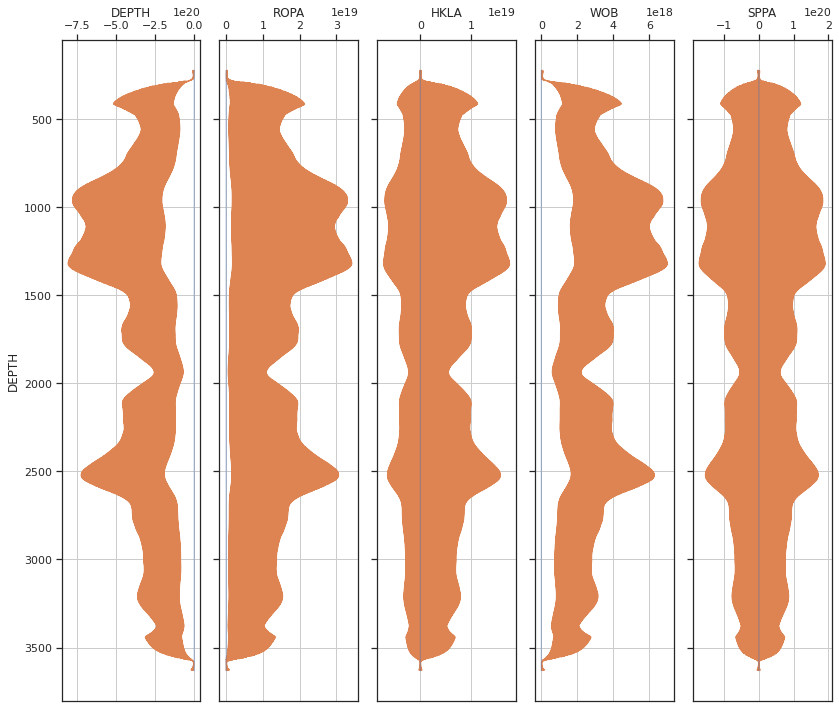

In [41]:
original = []
generated = []

t = X_test[y_name].astype(float).values
plt.figure(figsize=(14, 10))
for i, curve_name in enumerate(required_params):
    plt.subplot(1, len(df.columns) - 1, i + 1)

    zis = range(0, len(X_test) - window, step)
    A = np.zeros((len(zis), len(X_test))) * np.nan
    for zi, x in tqdm(enumerate(zis)):
        A[zi, np.arange(x, x+window, sparse_rate)] = Z[zi][0][:, i]
    
    A = np.nanmean(A, axis=0)
    not_nan_inds = np.where(~np.isnan(A))[0]
    
#     original.append(X_test[curve_name].astype(float).values)
#     generated.append(A[not_nan_inds])
    
    plt.plot(A[not_nan_inds], t[not_nan_inds], color='C1', lw=1)
    plt.plot(X_test[curve_name].astype(float).values, t, lw=1, color='C0', alpha=0.5)
    plt.grid()
    axis = plt.gca()
    axis.invert_yaxis()
    axis.xaxis.tick_top()
    axis.xaxis.set_label_position('top')
    if i > 0: axis.set_yticklabels([])

    if i == 0:
        plt.ylabel(f'{y_name}')
    plt.xlabel(f'{curve_name}')

plt.tight_layout()
# plt.savefig('images/CBA.png')

In [42]:
# for i in required_params[:-1]:
#     sns.displot(data=df_some, 
#             x=i, hue='WELL', kind='kde',
#             fill=True, palette=sns.color_palette('bright')[:2], height=5, aspect=1.5
#                )